In [1]:
import sqlite3 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import plotly.plotly as py
import plotly.graph_objs as go
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix 
from sklearn import metrics 
from sklearn.metrics import roc_curve, auc 
from nltk.stem.porter import PorterStemmer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning:

This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.



# Loading the data

In [0]:
final_data = pd.read_csv("final.csv")

final_data = final_data.drop(["Text"], axis = 1)
final_data = final_data.drop(final_data.columns[0], axis = 1)

# Sorting and train/test split

In [0]:
labels = final_data.Score
final_data = final_data.sort_values("Time")
final_data.shape

In [0]:
n = final_data.shape[0]
train_size = 0.7

train_set = final_data.iloc[:int(n*train_size)]
test_set =final_data.iloc[int(n*train_size):]

X_train = train_set.CleanedText
y_train = train_set.Score

X_test = test_set.CleanedText
y_test= test_set.Score

# Cleaning the data

In [7]:
import nltk
nltk.download('stopwords')
import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

[nltk_data] Downloading package stopwords to /content/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
{'am', 'below', 'through', 'mustn', 'mightn', 'itself', "didn't", 'm', 'the', 'haven', 'couldn', 'no', 's', 'most', 'me', 'herself', 'did', 'during', "couldn't", 'for', 'to', "won't", 'until', 'have', 'its', "doesn't", 'ourselves', "she's", 'theirs', 'aren', 'hadn', 'isn', 'but', 'just', 'at', 'hers', 're', 'weren', 'ours', "you're", 'does', 'd', 'his', 'ma', 'myself', 'on', 'has', 'we', 'now', 'a', 'himself', 'after', 'shan', 'once', 'who', 'or', "shan't", 'some', 'this', 'off', 'yourself', 'do', 'before', 't', 'as', 'of', 'because', 'will', 'y', 'needn', 've', 'her', 'they', "shouldn't", 'with', 'him', 'other', "it's", "isn't", 'yourselves', 'over', 'them', 'under', 'when', 'too', 'is', 'had', 'above', "haven't", 'same', 'our', 'about', 'being', 'didn', 'wouldn', "aren't", 'those', 'are', 'while', 'o', "don't", 'only', 'what', 'so', 'more', 'own', 'very', 'their',

- - -

# Creating Word2vec model

In [0]:
import gensim
i=0
train_sent=[]
for sent in X_train:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    train_sent.append(filtered_sentence)
    

In [0]:
test_sent=[]
for sent in X_test:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunc(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    test_sent.append(filtered_sentence)

In [0]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

w2v_model = gensim.models.Word2Vec(train_sent,min_count=5,size=50, workers=4)    

- - -

## Average Word2Vec

In [12]:
#AVG-W2V
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            cnt_words = 1
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

254919
50


In [13]:
sent_vectors2 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            cnt_words = 1
            pass
    sent_vec /= cnt_words
    sent_vectors2.append(sent_vec)
print(len(sent_vectors2))
print(len(sent_vectors2[0]))

109252
50


In [0]:
X_train1 = sent_vectors
X_test1 = sent_vectors2

# Applying DecisionTree Classifier


The optimal depth of the tree is 8.


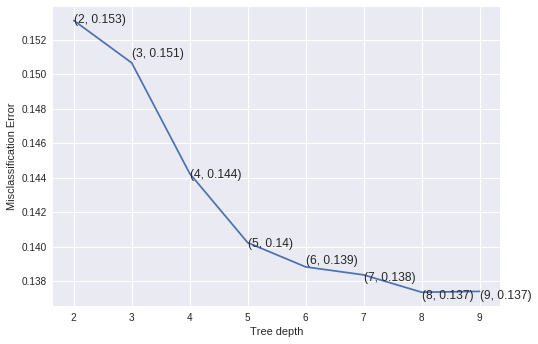

In [17]:
from sklearn.tree import DecisionTreeClassifier


depth = list(range(2,10))


# empty list that will hold cv scores
cv_scores = []
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train1)]
# perform 10-fold cross validation
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split = 1000, min_samples_leaf = 500)
    scores = cross_val_score(dt, X_train1, y_train, cv = my_cv, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_d = depth[MSE.index(min(MSE))]
print('\nThe optimal depth of the tree is %d.' % optimal_d)

# plot misclassification error vs k 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Tree depth')
plt.ylabel('Misclassification Error')
plt.show()

In [18]:


dt = DecisionTreeClassifier(max_depth = 8, min_samples_split = 1000, min_samples_leaf = 500)
dt.fit(X_train1,y_train)
pred = dt.predict(X_test1)

acc = accuracy_score(y_test, pred, normalize=True) * float(100)
x = dt.predict(X_train1)
tr_acc = accuracy_score(y_train, x, normalize=True) * float(100)
print('\n****Train accuracy for k = {} is {:.2f}'.format(8,tr_acc))
print('\n****Test accuracy for k = {} is {:.2f}'.format(8,acc))


****Train accuracy for k = 8 is 87.32

****Test accuracy for k = 8 is 85.31


- - - 

# Word2Vec-Tfidf

### Note : Performed with sampled 50k datapoints

In [12]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer


tf_idf_vect = TfidfVectorizer()
final_tf_idf = tf_idf_vect.fit_transform(X_train)
tfidf_feat = tf_idf_vect.get_feature_names()
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

train_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in train_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
            
        except:
            weight_sum = 1
            pass

    sent_vec /= weight_sum
    #print(np.isnan(np.sum(sent_vec)))

    train_vectors.append(sent_vec)
    row += 1
print(len(train_vectors))
print(len(train_vectors[0]))

35000
50


In [13]:

final_tf_idf = tf_idf_vect.fit_transform(X_test)
tfidf_feat = tf_idf_vect.get_feature_names()
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

test_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in test_sent: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum = 0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model2.wv[word]
            # obtain the tf_idf of a word in a sentence/review
            tfidf = final_tf_idf[row, tfidf_feat.index(word)]
            sent_vec += (vec * tfidf)
            weight_sum += tfidf
            
            
        except:
            weight_sum = 1
            pass

    sent_vec /= weight_sum
    #print(np.isnan(np.sum(sent_vec)))

    test_vectors.append(sent_vec)
    row += 1
print(len(test_vectors))
print(len(test_vectors[0]))

15000
50


In [0]:
X_train2 = train_vectors
X_test2 = test_vectors

# Applying DecisionTree Classifier


The optimal depth of the tree is 6.


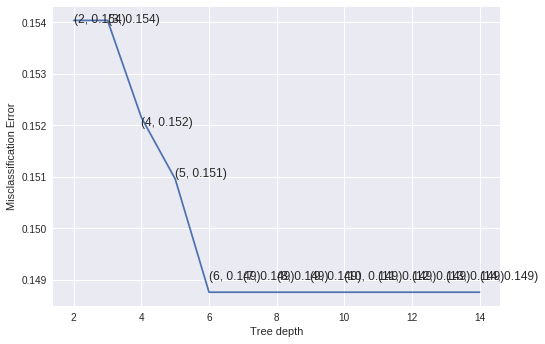

In [15]:
from sklearn.tree import DecisionTreeClassifier


depth = list(range(2,15))

# empty list that will hold cv scores
cv_scores = []
my_cv = [(train,test) for train, test in TimeSeriesSplit(n_splits=10).split(X_train2)]
# perform 10-fold cross validation
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split = 500, min_samples_leaf = 100)
    scores = cross_val_score(dt, X_train2, y_train, cv = my_cv, scoring='accuracy')
    cv_scores.append(scores.mean())
    
    
# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_d = depth[MSE.index(min(MSE))]
print('\nThe optimal depth of the tree is %d.' % optimal_d)

# plot misclassification error vs k 
plt.plot(depth, MSE)

for xy in zip(depth, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Tree depth')
plt.ylabel('Misclassification Error')
plt.show()

In [17]:

dt = DecisionTreeClassifier(max_depth = 6, min_samples_split = 500, min_samples_leaf = 100)
dt.fit(X_train2,y_train)
pred = dt.predict(X_test2)

acc = accuracy_score(y_test, pred, normalize=True) * float(100)
x = dt.predict(X_train2)
tr_acc = accuracy_score(y_train, x, normalize=True) * float(100)
print('\n****Train accuracy for k = {} is {:.2f}'.format(6,tr_acc))
print('\n****Test accuracy for k = {} is {:.2f}'.format(6,acc))


****Train accuracy for k = 6 is 86.09

****Test accuracy for k = 6 is 83.13


- - - 

# Conclusion


- ### Average word2vec gives a training accuracy of 87.3 % and testing accuracy of 85.3 % with best depth of tree being '8'.

- ### Tf-idf word2vec gives a training accuracy of 86 % and testing accuracy of 83.1 % with best depth of tree being '6'.

